In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')
import pickle

In [4]:
movies_df = pd.read_csv("./ML_test/preprocessed_movies.csv")
ratings_df = pd.read_csv("./ratings_small.csv")
# 장르 데이터를 one-hot 벡터로 변환
movies_df['genres'] = movies_df['genres'].apply(lambda x: ' '.join(eval(x)))
cv = CountVectorizer()
genres_one_hot = cv.fit_transform(movies_df['genres'])
genres_df = pd.DataFrame(genres_one_hot.toarray(), columns=cv.get_feature_names_out())
print("Genres One-Hot Encoded")
print(genres_df.head())

# 영화 데이터와 평점 데이터에서 일치하는 영화 ID만 필터링
ratings_movie_ids = ratings_df['movieId'].unique()
movies_movie_ids = movies_df['id'].unique()
common_movie_ids = set(movies_movie_ids).intersection(set(ratings_movie_ids))
filtered_movies_df = movies_df[movies_df['id'].isin(common_movie_ids)]
filtered_ratings_df = ratings_df[ratings_df['movieId'].isin(common_movie_ids)]
print("Filtered Movies and Ratings Data by Common IDs")
print(filtered_movies_df.head())
print(filtered_ratings_df.head())

# 평점 데이터의 평균 평점과 평점 개수 계산
filtered_ratings_mean_count = filtered_ratings_df.groupby('movieId').agg({'rating': ['mean', 'count']})
filtered_ratings_mean_count.columns = ['rating_mean', 'rating_count']
print("Calculated Mean and Count of Ratings")
print(filtered_ratings_mean_count.head())

# 영화 데이터와 평점 데이터 병합
filtered_movies_ratings_merged = pd.merge(filtered_movies_df, filtered_ratings_mean_count, left_on='id', right_index=True, how='left')
print("Merged Movies and Ratings Data")
print(filtered_movies_ratings_merged.head())

# 장르 데이터에 대한 NearestNeighbors 모델 학습
filtered_genres_df = genres_df.loc[filtered_movies_df.index]
nbrs_filtered = NearestNeighbors(n_neighbors=10, metric='cosine').fit(filtered_genres_df)
print("Trained NearestNeighbors Model on Filtered Genre Data")
print(nbrs_filtered)

# "The Dark Knight"의 인덱스 찾기 및 추천 목록 생성
filtered_movies_df_reset = filtered_movies_df.reset_index()
filtered_dark_knight_idx = filtered_movies_df_reset[filtered_movies_df_reset['title'] == 'The Dark Knight'].index[0]
distances, indices = nbrs_filtered.kneighbors([filtered_genres_df.iloc[filtered_dark_knight_idx]])
dark_knight_recommendations = filtered_movies_ratings_merged.iloc[indices[0]][['title', 'id']]
dark_knight_recommendations['distance'] = distances[0]
print("Generated Recommendations for 'The Dark Knight'")
print(dark_knight_recommendations)

# 추천 목록에 평점 정보 추가
dark_knight_recommendations = pd.merge(dark_knight_recommendations, filtered_movies_ratings_merged[['id', 'rating_mean', 'rating_count']], on='id', how='left')
print("Added Rating Information to Recommendations")
print(dark_knight_recommendations)

# Evaluation
# 테스트 데이터 생성
# 사용자별로 평점 4 이상인 영화를 선호 영화로 간주
preferred_movies = ratings_df[ratings_df['rating'] >= 4].groupby('userId')['movieId'].apply(list).to_dict()

# 추천 시스템을 사용하여 각 사용자에 대한 영화 추천 목록을 생성
# 예를 들어, 다음 함수는 각 사용자에 대해 10개의 영화를 추천.+
def generate_recommendations(user_id, n_recommendations=10):
    # 추천 로직 구현 (예시)
    # 여기서는 단순히 임의의 영화를 추천하는 것으로 가정합니다.
    return movies_df.sample(n_recommendations)['id'].tolist()


user_recommendations = {user: generate_recommendations(user) for user in preferred_movies.keys()}

# 평가
precisions = []
recalls = []
f1_scores = []

for user, preferred in preferred_movies.items():
    recommended = user_recommendations[user]

    true_positives = len(set(preferred) & set(recommended))
    false_positives = len(set(recommended) - set(preferred))
    false_negatives = len(set(preferred) - set(recommended))

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# 평균 평가 점수
avg_precision = sum(precisions) / len(precisions)
avg_recall = sum(recalls) / len(recalls)
avg_f1_score = sum(f1_scores) / len(f1_scores)

print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1_score}")



Genres One-Hot Encoded
   action  adventure  animation  comedy  crime  documentary  drama  family  \
0       0          0          1       1      0            0      0       1   
1       0          1          0       0      0            0      0       1   
2       0          0          0       1      0            0      0       0   
3       0          0          0       1      0            0      1       0   
4       0          0          0       1      0            0      0       0   

   fantasy  fiction  ...  horror  movie  music  mystery  romance  science  \
0        0        0  ...       0      0      0        0        0        0   
1        1        0  ...       0      0      0        0        0        0   
2        0        0  ...       0      0      0        0        1        0   
3        0        0  ...       0      0      0        0        1        0   
4        0        0  ...       0      0      0        0        0        0   

   thriller  tv  war  western  
0         0  

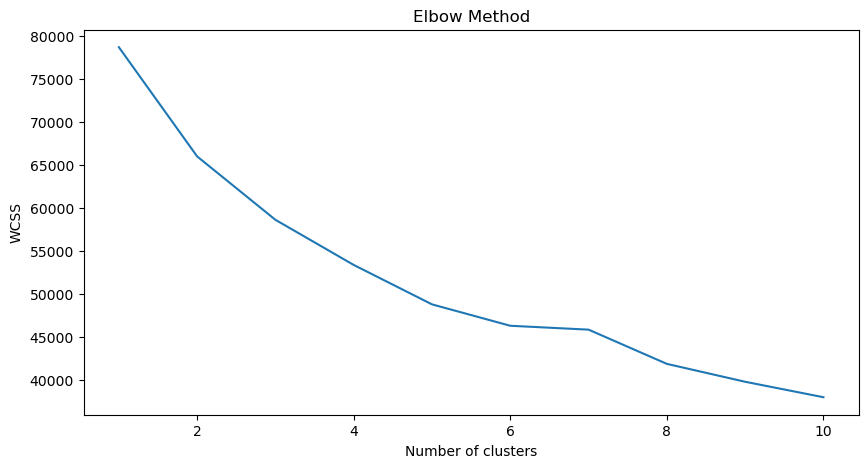

Average Silhouette Score: 0.24023176981722041
                                       title  \
cluster                                        
0       10719               The Family Stone   
        45310                        Popcorn   
        7469                       Bedazzled   
        43167              A Year and Change   
1       37795                      Deewangee   
        37575                       Triple 9   
        22037                      Sorceress   
        44786             Kubrick Remembered   
2       30048           Emanuelle in America   
        34831                       Aflatoon   
        41522                      The Model   
        2327                         Rocky V   
3       12183          Daft Punk's Electroma   
        18324                 Queen of Blood   
        2727   Universal Soldier: The Return   
        1156                    Delicatessen   

                                           genres  
cluster                              

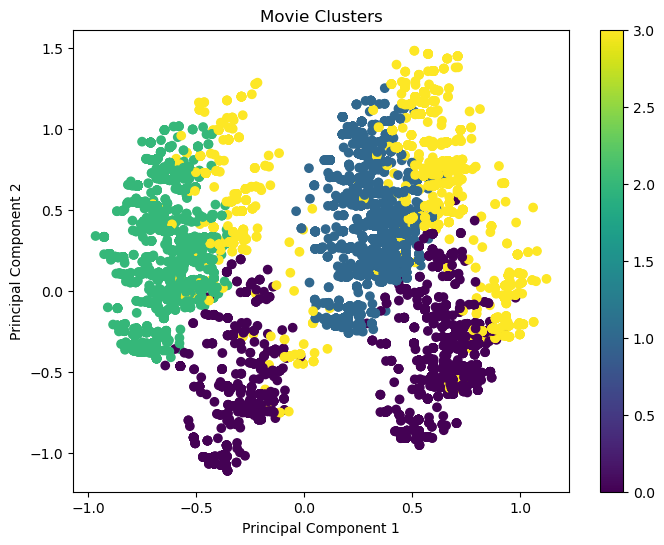

In [5]:
# 데이터 로딩
movies_df = pd.read_csv("./ML_test/preprocessed_movies.csv")

# 장르 데이터 전처리
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.strip('[]').replace('\'', '').split(', '))
movies_df['genres_joined'] = movies_df['genres'].apply(lambda x: ' '.join(x))

# CountVectorizer를 사용하여 장르 데이터를 원-핫 인코딩
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(movies_df['genres_joined'])

# Elbow 방법을 사용하여 적절한 클러스터 수 결정
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Elbow 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# 실제 클러스터링 (4개의 클러스터 사용)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(X)


# 실루엣 점수 계산
silhouette_avg = silhouette_score(X, clusters)
print(f"Average Silhouette Score: {silhouette_avg}")

# 클러스터 결과를 영화 데이터프레임에 추가
movies_df['cluster'] = clusters

# 각 클러스터에 속하는 영화의 예시 확인
cluster_examples = movies_df.groupby('cluster').apply(lambda x: x.sample(4))[['title', 'genres']]
print(cluster_examples)

# 사용자 선호 클러스터 결정 예시 (여기서는 예시로 클러스터 0을 선호한다고 가정)
preferred_cluster = 0

# 선호 클러스터 내 영화 추천
recommended_movies = movies_df[movies_df['cluster'] == preferred_cluster].sample(10)
print("Recommended Movies:")
print(recommended_movies[['title', 'genres']])

# PCA를 사용하여 차원 축소
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

# 클러스터 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Movie Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
movies = pd.read_csv("./movies.csv")
ratings = pd.read_csv("./ratings.csv")

movies = movies.rename(columns={"id":"movieId"})
movies["movieId"] = movies["movieId"].astype("int64")
print("Movies: ")
print(movies[['movieId', 'title']])

ratings.pivot(index="userId", columns="movieId", values="rating")

def create_user_item_matrix(ratings) -> pd.DataFrame:
    mat = ratings.pivot(index="userId", columns="movieId", values="rating")
    # Treat movies rated by users as 'seen' and assign a value of 1
    mat[~mat.isna()] = 1
    # Treat movies not rated by users as 'unseen' and assign a value of 0
    mat.fillna(0, inplace=True)
    return mat

user_item_matrix = create_user_item_matrix(ratings)
print(user_item_matrix)

def get_svd_prediction(user_item_matrix, k):
    # Obtain U, sigma, V
    u, s, vh = scipy.sparse.linalg.svds(user_item_matrix.to_numpy(), k=k)
    # Reconstruct the original matrix using these components
    preds = np.dot(np.dot(u, np.diag(s)), vh)

    # Convert the result to a DataFrame and normalize values between 0 and 1
    preds = pd.DataFrame(preds, columns=user_item_matrix.columns, index=user_item_matrix.index)
    preds = (preds - preds.min()) / (preds.max() - preds.min())
    return preds

predictions = get_svd_prediction(user_item_matrix, k=64)
print("Prediction")
print(predictions)

user_id = 602
user_movie_ids = ratings[ratings.userId == user_id].movieId
user_movies = movies[movies.movieId.isin(user_movie_ids)]
print(user_id, "유저가 본 영화 목록")
print(len(user_movies), user_movies)

# Retrieve user predictions and exclude already watched movies
user_predictions = predictions.loc[user_id].sort_values(ascending=False)
user_predictions = user_predictions[~user_predictions.index.isin(user_movie_ids)]
# Get the top 10 movies with the highest predicted values
user_predictions = user_predictions.head(10)

# Retrieve information about the top 10 recommended movies
user_recommendations_item = movies[movies.movieId.isin(user_predictions.index)]
user_recommendations_item["recommendation_score"] = user_predictions.values
print("Movies the user hasn't watched and recommended:")
print(user_recommendations_item["movieId"])

class SVD:
    def __init__(self, ratings, movies, k):
        user_item_matrix = create_user_item_matrix(ratings)
        self.preds = get_svd_prediction(user_item_matrix, k)
        self.ratings = ratings
        self.movies = movies

    def get_recommendations(self, user_id, top_k=300):
        user_movie_ids = self.ratings[self.ratings.userId == user_id].movieId
        user_movies = self.movies[self.movies.movieId.isin(user_movie_ids)]

        # Retrieve user predictions and exclude already watched movies
        user_predictions = self.preds.loc[user_id].sort_values(ascending=False)
       
        user_predictions = user_predictions[~user_predictions.index.isin(user_movie_ids)]
        # Get information about the top_k recommended movies
        user_recommendations = self.movies[self.movies.movieId.isin(user_predictions.index)]
        user_recommendations["recommendation_score"] = user_predictions.values

        return user_recommendations if top_k is None else user_recommendations.head(top_k)
    
svd = SVD(ratings, movies, 64)
svd.get_recommendations(user_id)

# Save the trained model to a file
with open('svd_model.pkl', 'wb') as file:
    pickle.dump(svd, file)

print("Model saved successfully.")


Movies: 
      movieId                                      title
0           1                           Toy Story (1995)
1           2                             Jumanji (1995)
2           3                    Grumpier Old Men (1995)
3           4                   Waiting to Exhale (1995)
4           5         Father of the Bride Part II (1995)
...       ...                                        ...
9737   193581  Black Butler: Book of the Atlantic (2017)
9738   193583               No Game No Life: Zero (2017)
9739   193585                               Flint (2017)
9740   193587        Bungo Stray Dogs: Dead Apple (2018)
9741   193609        Andrew Dice Clay: Dice Rules (1991)

[9742 rows x 2 columns]
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           1.0     0.0     1.0     0.0     0.0     1.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0  

In [7]:
# Define a function to calculate F1 score
def f1_score_(svd, user_id, target_movie_ids, k=20):

    # Get the top-k recommendations for the user
    # 주어진 사용자 ID에 대한 top-k 추천 목록을 생성
    rec = svd.get_recommendations(user_id, k).movieId
    
#     content-based에서 나온 것들 추가하는 파트 rec에서 예측하지 못한 것들에 대해 추가
    for _,i in enumerate(user_recommendations[user_id]):
        if i in rec.values:
            None
        else:
            a = pd.DataFrame([i])
            rec = pd.concat([rec,a])
    for i in range(len(recommended_movies)):
        value = movies_df[movies_df["title"] == recommended_movies["title"].iloc[0]]["id"].values[0]
        if value in rec.values:
            None
        else:
            a = pd.DataFrame([value])
            rec = pd.concat([rec,a])
    # Calculate the number of true positives
    # 추천 목록에 타겟 영화 세트에 포함된 영화가 있는지 확인
    tp = len(rec[rec.isin(target_movie_ids)].dropna())
    # Calculate the number of false positives
    fp = len(rec) - tp
    # Calculate the number of false negatives
    # 타겟 영화 세트에 포함된 영화 중 추천되지 않은 영화의 수를 계산
    fn = len(target_movie_ids) - tp
    # Calculate the precision
    precision = tp / (tp + fp)
    # Calculate the recall
    recall = tp / (tp + fn)

    # Calculate the F1 score
    f1 = 2 * precision * recall / (precision + recall)if precision + recall != 0 else 0

    return f1
    
# Calculate the average F1 score across all users
average_f1 = (
    sum([f1_score_(svd, user_id, preferred_movies[user_id]) for user_id in ratings.userId.unique()])
    / len(ratings.userId.unique())
)
print(f"Average F1 score: {average_f1:.2f}")


Average F1 score: 0.02
